# Prompt engineering

In [15]:
import re
import string
import numpy as np
from math import pi
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

# import other python files
from utils_benchmark import *
from utils import *
from elaboration import *
from similarity import *
from flexibility import *
from process_humans_data import *

In [4]:
%load_ext autoreload
%autoreload 2

## Load data

In [18]:
humans = pd.read_csv('./data_processed/humans_data_processed.csv')

# prompt 1: baseline
gpt_35_processed_p1 = pd.read_csv('./data_processed/prompt_1/gpt35_merged_343.csv')
gpt_4_processed_p1  = pd.read_csv('./data_processed/prompt_1/gpt4_merged_398.csv')

# prompt 2: wo_creative_constraint
gpt_35_processed_p2 = pd.read_csv('./data_processed/prompt_2/gpt35_merged_329.csv')
gpt_4_processed_p2  = pd.read_csv('./data_processed/prompt_2/gpt4_merged_372.csv')

# prompt 3: wo_length_constraint
gpt_35_processed_p3 = pd.read_csv('./data_processed/prompt_3/gpt35_merged_359.csv')
gpt_4_processed_p3 = pd.read_csv('./data_processed/prompt_3/gpt4_merged_391.csv')

# prompt 4: wo_persona
gpt_35_processed_p4 = pd.read_csv('./data_processed/prompt_4/gpt35_merged_363.csv')
gpt_4_processed_p4 = pd.read_csv('./data_processed/prompt_4/gpt4_merged_395.csv')

# prompt 5: wo_persona_and_context
gpt_35_processed_p5 = pd.read_csv('./data_processed/prompt_5/gpt35_merged_341.csv')
gpt_4_processed_p5 = pd.read_csv('./data_processed/prompt_5/gpt4_merged_375.csv')

# prompt 6: same humans: "What is a surprising use for...?"
gpt_35_processed_p6 = pd.read_csv('./data_processed/prompt_6/gpt35_merged_317.csv')
gpt_4_processed_p6 = pd.read_csv('./data_processed/prompt_6/gpt4_merged_393.csv')

# prompt 7: wo_creative_constraint_and_length_constraint
gpt_35_processed_p7 = pd.read_csv('./data_processed/prompt_7/gpt35_merged_325.csv')
gpt_4_processed_p7 = pd.read_csv('./data_processed/prompt_7/gpt4_merged_386.csv')

# prompt 5 fs max
gpt_35_processed_5_fs_max = pd.read_csv('./data_processed/prompt_fs_1_max/gpt35_merged_5_fs_330.csv')
gpt_4_processed_5_fs_max = pd.read_csv('./data_processed/prompt_fs_1_max/gpt4_merged_5_fs_392.csv')

# prompt 5 fs random
gpt_35_processed_5_fs_random = pd.read_csv('./data_processed/prompt_fs_1_random/gpt35_merged_5_fs_344.csv')
gpt_4_processed_5_fs_random = pd.read_csv('./data_processed/prompt_fs_1_random/gpt4_merged_5_fs_393.csv')

# prompt 5 fs random with scores 
gpt_35_processed_5_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt35_merged_5_fs_339.csv')
gpt_4_processed_5_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt4_merged_5_fs_392.csv')

# prompt 10 fs random with scores 
gpt_35_processed_10_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt35_merged_10_fs_316.csv')
gpt_4_processed_10_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt4_merged_10_fs_393.csv')

# prompt 20 fs random with scores 
gpt_35_processed_20_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt35_merged_20_fs_275.csv')
gpt_4_processed_20_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt4_merged_20_fs_382.csv')

In [21]:
# normalize 
combined_data = pd.concat([
    humans.assign(dataset='Humans'),
    gpt_4_processed_p1.assign(dataset='GPT-4 prompt 1'),
    gpt_4_processed_p2.assign(dataset='GPT-4 prompt 2'),
    gpt_4_processed_p3.assign(dataset='GPT-4 prompt 3'),
    gpt_4_processed_p4.assign(dataset='GPT-4 prompt 4'),
    gpt_4_processed_p5.assign(dataset='GPT-4 prompt 5'),
    gpt_4_processed_p6.assign(dataset='GPT-4 prompt 6'),
    gpt_4_processed_p7.assign(dataset='GPT-4 prompt 7'),
    gpt_4_processed_5_fs_max.assign(dataset='GPT-4 prompt 5 fs max'),
    gpt_4_processed_5_fs_random.assign(dataset='GPT-4 prompt 5 fs random'),
    gpt_4_processed_5_fs_scores.assign(dataset='GPT-4 prompt 5 fs random w/ scores'),
    gpt_4_processed_10_fs_scores.assign(dataset='GPT-4 prompt 10 fs random w/ scores'),
    gpt_4_processed_20_fs_scores.assign(dataset='GPT-4 prompt 20 fs random w/ scores'),
])

combined_data_norm = normalization_1(combined_data, check_norm = False)

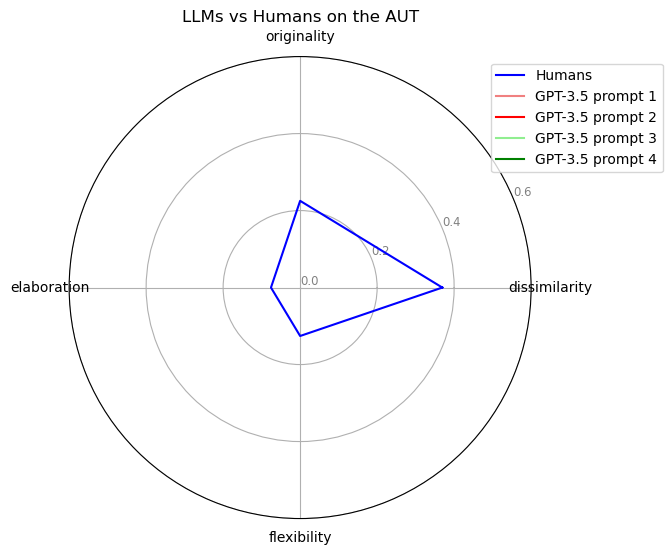

In [7]:
features = ['prompt', 'dissimilarity', 'originality', 'elaboration', 'flexibility']

humans_norm = combined_data_norm[combined_data_norm['dataset'] == 'Humans']
gpt_35_norm_p1 = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5 prompt 1']
gpt_35_norm_p2 = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5 prompt 2']
gpt_35_norm_p3 = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5 prompt 3']
gpt_35_norm_p4 = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5 prompt 4']
#gpt_35_norm_p5 = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5 prompt 5']
#gpt_35_norm_p6 = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5 prompt 6']

# List of dataframes and corresponding titles
dataframes = [humans_norm[features], gpt_35_norm_p1[features], gpt_35_norm_p2[features], gpt_35_norm_p3[features], gpt_35_norm_p4[features]]#, gpt_35_norm_p5[features], gpt_35_norm_p6[features]]
titles = ['Humans', 'GPT-3.5 prompt 1', 'GPT-3.5 prompt 2', 'GPT-3.5 prompt 3', 'GPT-3.5 prompt 4']#, 'GPT-3.5 prompt 5', 'GPT-3.5 prompt 6']
colors = ['blue', 'lightcoral', 'red', 'lightgreen', 'green']

# Plot radar chart for multiple dataframes
plot_radar_chart(dataframes, titles, colors, avg_per_object = True)

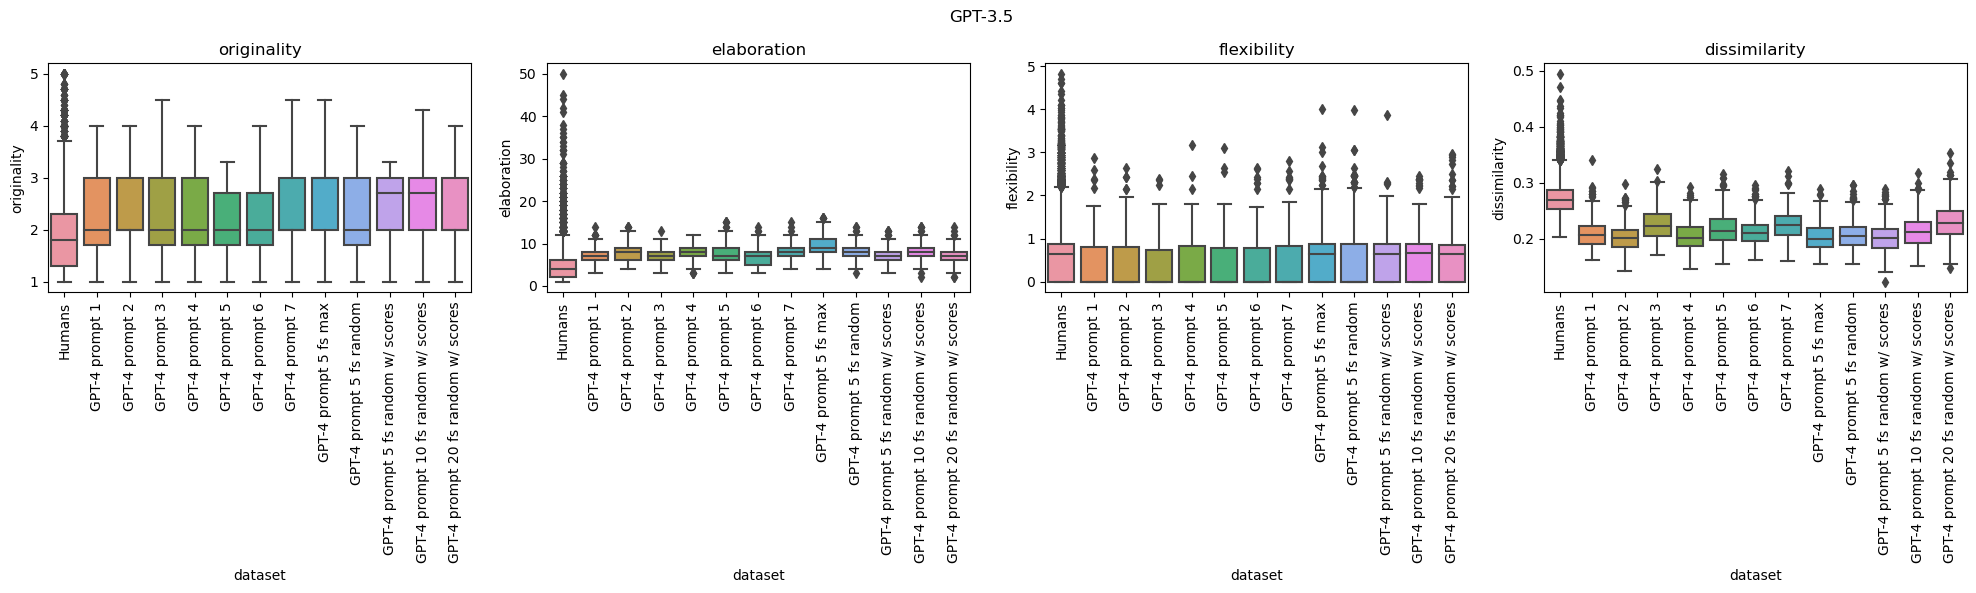

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
for i, feat in enumerate(['originality', 'elaboration', 'flexibility', 'dissimilarity']):
    sns.boxplot(x='dataset', y=feat, data=combined_data, ax=axs[i])
    axs[i].set_title(feat)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
plt.suptitle("GPT-3.5")
plt.tight_layout()
plt.show()

In [ ]:
# comparison of few shot prompting


fig, axs = plt.subplots(1, 4, figsize=(20, 6))
for i, feat in enumerate(['originality', 'elaboration', 'flexibility', 'dissimilarity']):
    sns.boxplot(x='dataset', y=feat, data=combined_data, ax=axs[i])
    axs[i].set_title(feat)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
plt.suptitle("GPT-3.5")
plt.tight_layout()
plt.show()

**Number of samples with 0 flexibility score**

In [9]:
LLM_only = combined_data[combined_data['dataset'] != 'Humans']
for dataset in LLM_only['dataset'].unique():
    LLM_dataset = LLM_only[LLM_only['dataset'] == dataset]
    nb_0 = len(LLM_dataset[LLM_dataset['flexibility'] == 0])
    print(f"{dataset}: {nb_0} with missing flexibility values, {np.round(100*nb_0/len(LLM_dataset),2)}% missing values")

GPT-4 prompt 1: 251 with missing flexibility values, 63.07% missing values
GPT-4 prompt 2: 229 with missing flexibility values, 61.56% missing values
GPT-4 prompt 3: 246 with missing flexibility values, 62.92% missing values
GPT-4 prompt 4: 221 with missing flexibility values, 55.95% missing values
GPT-4 prompt 5: 231 with missing flexibility values, 61.6% missing values
GPT-4 prompt 6: 251 with missing flexibility values, 63.87% missing values
GPT-4 prompt 7: 228 with missing flexibility values, 59.07% missing values


### Radar charts per object

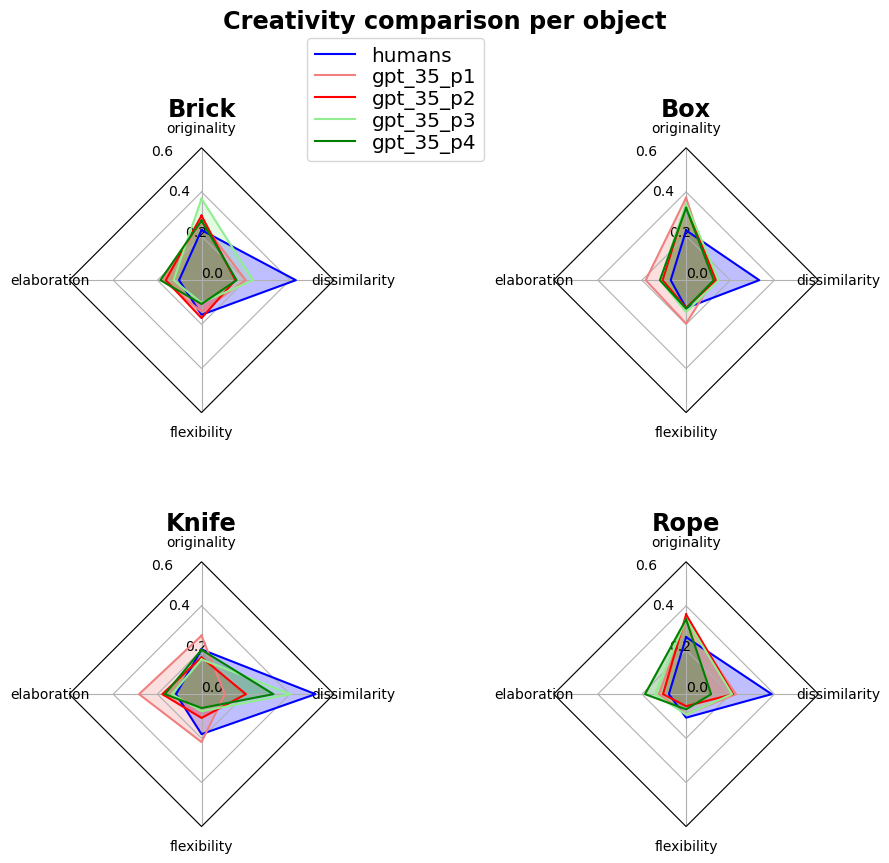

In [10]:
### PARAMETERS ###
data_dict = {"humans": humans, "gpt_35_p1": gpt_35_processed_p1, "gpt_35_p2": gpt_35_processed_p2, "gpt_35_p3": gpt_35_processed_p3, "gpt_35_p4": gpt_35_processed_p4}
features = ["originality", "elaboration", "flexibility", "dissimilarity"]
#################

objects = ["brick", "box", "knife", "rope"]
normalized_data = prepare_data_for_radar_chart_per_object(data_dict, objects)
brick_norm, box_norm, knife_norm, rope_norm = normalized_data["brick_norm"], normalized_data["box_norm"], normalized_data["knife_norm"], normalized_data["rope_norm"]
dataframes = [brick_norm, box_norm, knife_norm, rope_norm]
colors = ['blue', 'lightcoral', 'red', 'lightgreen', 'green']
titles = data_dict.keys()

radar_charts_per_object(brick_norm, box_norm, knife_norm, rope_norm, features, model_names = list(data_dict.keys()), colors = colors)

### Univariate analysis

In [11]:
print(combined_data[(combined_data['dataset'] == 'GPT-4 prompt 7') & (combined_data['prompt'] == 'knife')]['originality'].median())
combined_data[(combined_data['dataset'] == 'GPT-4 prompt 7') & (combined_data['prompt'] == 'knife')]['originality'].value_counts()

2.0


originality
2.0    52
3.0    22
1.7    18
1.0     5
4.5     1
1.3     1
Name: count, dtype: int64

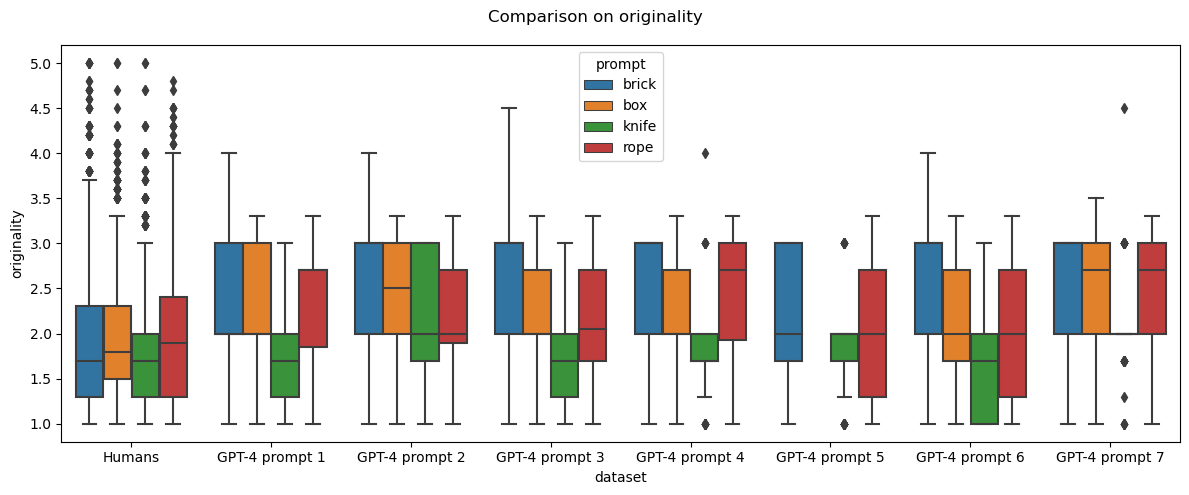

In [13]:
plot_per_object(type = "boxplot", data_dict = data_dict, features = ["originality"], combined_data = combined_data)